In [8]:
#load path
import os
import sys
import astropy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.time import Time
from astropy.wcs import WCS
from photutils.aperture import CircularAperture, aperture_photometry, CircularAnnulus
from astropy.visualization import (ImageNormalize, MinMaxInterval,PercentileInterval,SqrtStretch)
import glob


In [9]:
path='./data/'
rawpath=r'/Users/matteo/Google Drive/My Drive/TelescopeData/NEW CAMERA/'
calibpath='./data/Calibs/'
reduxpath='./data/Redux/'
combinepath='./data/Redux/Combined/'
gain=0.25 #e-/ADU at G = 125

In [10]:
def makeflat(flatlist,masterbias):
    flatshape=fits.open(flatlist[0])[0].data
    masterflat=np.zeros((len(flatlist),flatshape.shape[0],flatshape.shape[1]))
    for ii,img in enumerate(flatlist):
        hdu=fits.open(img)
        masterflat[ii,:,:]=hdu[0].data-masterbias
    masterflat=np.median(masterflat,axis=0)
    normflat=masterflat/np.median(masterflat)
    return normflat

In [11]:
for root, dirs, files in os.walk(rawpath):
  if 'BIAS' in dirs:
    date = root.split('/')[-1]
    #skip dates before September 2025
    t = Time(date, scale='utc')
    if t<Time('2025-09-01', scale='utc'):
        continue
    bias_dir = os.path.join(root, 'BIAS')
    biaslist=glob.glob(bias_dir+'/*BIAS*.fits')
    #Now process bias frames
    if len(biaslist)>0:
        night = date.replace('-','')
        print('Number of bias frames found: {} in dir {}'.format(len(biaslist), bias_dir))
        if os.path.exists(calibpath+'/MasterBias_{}.fits'.format(night)):
            print('Master bias for night {} already exists, skipping.'.format(night))
            continue
        biasshape=fits.open(biaslist[0])[0].data
        masterbias=np.zeros((len(biaslist),biasshape.shape[0],biasshape.shape[1]))
        #print(masterbias.shape)

        for ii,img in enumerate(biaslist):
            hdu=fits.open(img)
            masterbias[ii,:,:]=hdu[0].data

        masterbias=np.median(masterbias,axis=0)
        #display master bias
        #plt.imshow(masterbias,cmap='gray',norm=ImageNormalize(masterbias,interval=MinMaxInterval(),stretch=SqrtStretch()))
        #print median value and variance of the bias frame
        print('  Master bias median value: {:.2f} ADU'.format(np.median(masterbias)))
        print('  Single bias variance: {:.2f} ADU, {:.2f} e-'.format(np.var(biasshape), np.var(biasshape)*gain))
        if np.median(masterbias)>200:
            print('WARNING: Unusually bright bias frames, please check your calibration set.')
        #save as fits

        #convert masterbias to 32 bit float
        fits.writeto(calibpath+'/MasterBias_{}.fits'.format(night),masterbias.astype(np.float32),overwrite=True)



Number of bias frames found: 20 in dir /Users/matteo/Google Drive/My Drive/TelescopeData/NEW CAMERA/2025-11-03/BIAS
Master bias for night 20251103 already exists, skipping.
Number of bias frames found: 20 in dir /Users/matteo/Google Drive/My Drive/TelescopeData/NEW CAMERA/2025-11-18/BIAS
Master bias for night 20251118 already exists, skipping.
Number of bias frames found: 20 in dir /Users/matteo/Google Drive/My Drive/TelescopeData/NEW CAMERA/2025-11-27/BIAS
  Master bias median value: 161.00 ADU
  Single bias variance: 6.76 ADU, 1.69 e-
Number of bias frames found: 15 in dir /Users/matteo/Google Drive/My Drive/TelescopeData/NEW CAMERA/2025-09-25/BIAS
Master bias for night 20250925 already exists, skipping.
Number of bias frames found: 20 in dir /Users/matteo/Google Drive/My Drive/TelescopeData/NEW CAMERA/2025-10-30/BIAS
Master bias for night 20251030 already exists, skipping.
Number of bias frames found: 15 in dir /Users/matteo/Google Drive/My Drive/TelescopeData/NEW CAMERA/2025-10-24/

In [5]:
#Now process darks as a function of exptime
nightdark = '2025-10-22/DARK/'
darklist=glob.glob(rawpath+nightdark+'*DARK*.fits')
darkshape=fits.open(darklist[0])[0].data
masterdark=np.zeros((len(darklist),darkshape.shape[0],darkshape.shape[1]))
darkexptimes=np.zeros(len(darklist))
for ii,img in enumerate(darklist):
    hdu=fits.open(img)
    darkexptimes[ii]=hdu[0].header['EXPTIME']
    masterdark[ii,:,:]=hdu[0].data-masterbias
#find unique exptimes
uniqexptimes=np.unique(darkexptimes)
print(uniqexptimes)
meddarkvals = np.zeros((len(uniqexptimes)))
for exptime in uniqexptimes:
    darks=masterdark[darkexptimes==exptime,:,:]
    meddark=np.median(darks,axis=0)
    #plt.imshow(meddark,cmap='gray',norm=ImageNormalize(meddark,interval=MinMaxInterval(),stretch=SqrtStretch()))
    fits.writeto(calibpath+'/MasterDark_'+str(int(exptime))+'s.fits',meddark,overwrite=True)
    meddarkvals[uniqexptimes==exptime]=np.median(meddark)

print(meddarkvals)


[  10.  120.  300.  600. 1200. 1800.]
[ 0.   1.   2.   4.   7.5 11.5]


Dark current = 0.0016 e-/s 


Text(0.5, 1.0, 'Dark current = 0.0016 e-/s')

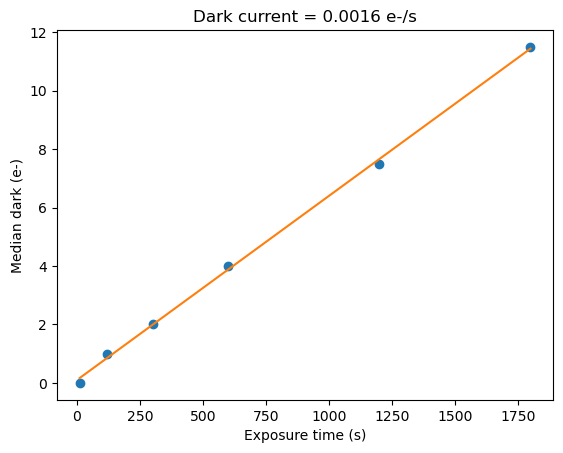

In [6]:
#fit a line to the median dark values vs exptime
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(uniqexptimes,meddarkvals)
print('Dark current = {:6.4f} e-/s '.format(slope*gain))
plt.plot(uniqexptimes,meddarkvals,'o')
plt.plot(uniqexptimes,slope*uniqexptimes+intercept)
plt.xlabel('Exposure time (s)')
plt.ylabel('Median dark (e-)')
plt.title('Dark current = {:6.4f} e-/s'.format(slope*gain))

In [12]:
#Now process flats
for root, dirs, files in os.walk(rawpath):
  if 'FLAT' in dirs:
    date = root.split('/')[-1]
    #skip dates before September 2025
    t = Time(date, scale='utc')
    if t<Time('2025-09-01', scale='utc'):
        continue
    flat_dir = os.path.join(root, 'FLAT')
    for filter in ['R','G','I','SII','OIII','Ha','Hb']:
        flatlist=glob.glob(flat_dir+'/*_FLAT*'+filter+'*.fits')
        if len(flatlist)>0:
            night = date.replace('-','')
            if os.path.exists(calibpath+'/MasterFlat_{}_{}.fits'.format(filter, night)):
              print('  Master Flat for night {} and filter {} already exists, skipping.'.format(night, filter))
              continue
            normflat=makeflat(flatlist,masterbias)
            #plt.imshow(normflat,cmap='gray',norm=ImageNormalize(normflat,interval=MinMaxInterval(),stretch=SqrtStretch()))
            fits.writeto(calibpath+'/MasterFlat_{}_{}.fits'.format(filter, night),normflat.astype(np.float32),overwrite=True)

  Master Flat for night 20251103 and filter R already exists, skipping.
  Master Flat for night 20251103 and filter G already exists, skipping.
  Master Flat for night 20251103 and filter I already exists, skipping.
  Master Flat for night 20251103 and filter SII already exists, skipping.
  Master Flat for night 20251103 and filter OIII already exists, skipping.
  Master Flat for night 20251103 and filter Ha already exists, skipping.
  Master Flat for night 20251103 and filter Hb already exists, skipping.
  Master Flat for night 20250930 and filter R already exists, skipping.
  Master Flat for night 20250930 and filter G already exists, skipping.
  Master Flat for night 20250930 and filter I already exists, skipping.
  Master Flat for night 20250930 and filter SII already exists, skipping.
  Master Flat for night 20250930 and filter OIII already exists, skipping.
  Master Flat for night 20250930 and filter Ha already exists, skipping.
  Master Flat for night 20250930 and filter Hb alre